# Cars Sales Prediction

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn as sk
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Data Analysing**

In [105]:
#Data Audit
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [106]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [107]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [108]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [109]:
cars = pd.read_excel('car_sales.xlsx')

In [110]:
cars.head(10)

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,...,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,...,2.639,13.2,28.0,2012-02-02 00:00:00,58.280150
1,Acura,TL,39.384,19.875,Passenger,...,3.517,17.2,25.0,2011-03-06 00:00:00,91.370778
2,Acura,CL,14.114,18.225,Passenger,...,3.470,17.2,26.0,2012-04-01 00:00:00,NaN
3,Acura,RL,8.588,29.725,Passenger,...,3.850,18.0,22.0,2011-10-03 00:00:00,91.389779
4,Audi,A4,20.397,22.255,Passenger,...,2.998,16.4,27.0,2011-08-10 00:00:00,62.777639
5,Audi,A6,18.780,23.555,Passenger,...,3.561,18.5,22.0,2011-09-08 00:00:00,84.565105
6,Audi,A8,1.380,39.000,Passenger,...,3.902,23.7,21.0,2/27/2012,134.656858
7,BMW,323i,19.747,NaN,Passenger,...,3.179,16.6,26.0,6/28/2011,71.191207
8,BMW,328i,9.231,28.675,Passenger,...,3.197,16.6,24.0,1/29/2012,81.877069
9,BMW,528i,17.527,36.125,Passenger,...,3.472,18.5,25.0,2011-04-04 00:00:00,83.998724


In [10]:
cars.describe(include='all')

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,101,101,101.000000,85.000000,101,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,99.000000,101,99.000000
unique,19,101,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,NaN
top,Ford,Integra,NaN,NaN,Passenger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/23/2012,NaN
freq,11,1,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
mean,NaN,NaN,59.405574,18.221059,NaN,28.854737,3.278000,195.440000,108.805000,71.801000,189.767000,3.487788,18.591000,23.303030,NaN,81.005865
std,NaN,NaN,77.964018,10.730210,NaN,15.066433,1.127756,60.300312,8.093549,3.596786,14.148313,0.660371,4.130818,4.509524,NaN,26.659060
min,NaN,NaN,0.110000,5.160000,NaN,9.235000,1.000000,55.000000,93.100000,62.600000,149.400000,1.895000,10.300000,15.000000,NaN,23.276272
25%,NaN,NaN,14.785000,11.525000,NaN,18.962500,2.500000,153.750000,104.000000,69.175000,180.000000,3.056500,16.000000,21.000000,NaN,62.472851
50%,NaN,NaN,29.450000,14.795000,NaN,24.997000,3.100000,194.000000,108.000000,71.450000,190.550000,3.470000,18.000000,23.000000,NaN,80.657696
75%,NaN,NaN,73.203000,20.525000,NaN,35.717500,4.000000,225.000000,113.000000,74.400000,199.775000,3.876000,20.000000,25.500000,NaN,92.645507


In [12]:
cars_conti_vars = cars.loc[:, (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[:, (cars.dtypes == 'object')]
cars_cat_vars

,Manufacturer,Model,Vehicle_type,Latest_Launch
0,Acura,Integra,Passenger,2012-02-02 00:00:00
1,Acura,TL,Passenger,2011-03-06 00:00:00
2,Acura,CL,Passenger,2012-04-01 00:00:00
3,Acura,RL,Passenger,2011-10-03 00:00:00
4,Audi,A4,Passenger,2011-08-10 00:00:00
...,...,...,...,...
96,Mercedes-B,SLK,Passenger,1/16/2011
97,Mercedes-B,SLK230,Passenger,2011-06-08 00:00:00
98,Mercedes-B,CLK Coupe,Passenger,2011-08-07 00:00:00
99,Mercedes-B,CL500,Passenger,2011-11-04 00:00:00


In [13]:
cars_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,101.0,0.0,5999.96,59.41,29.45,77.96,6078.39,0.11,0.92,3.31,6.54,14.78,29.45,73.20,155.79,220.65,276.75,540.56
__year_resale_value,85.0,16.0,1548.79,18.22,14.80,10.73,115.14,5.16,5.75,7.83,8.86,11.52,14.80,20.52,31.14,40.10,58.49,58.60
Price_in_thousands,99.0,2.0,2856.62,28.85,25.00,15.07,227.00,9.24,9.69,12.29,13.98,18.96,25.00,35.72,45.81,60.29,82.66,85.50
Engine_size,100.0,1.0,327.80,3.28,3.10,1.13,1.27,1.00,1.50,1.80,2.00,2.50,3.10,4.00,4.60,5.20,5.72,8.00
Horsepower,100.0,1.0,19544.00,195.44,194.00,60.30,3636.13,55.00,91.63,112.85,120.00,153.75,194.00,225.00,275.00,300.10,346.05,450.00
Wheelbase,100.0,1.0,10880.50,108.80,108.00,8.09,65.51,93.10,93.40,96.20,98.94,104.00,108.00,113.00,117.52,120.74,138.50,138.70
Width,100.0,1.0,7180.10,71.80,71.45,3.60,12.94,62.60,65.67,66.70,67.28,69.18,71.45,74.40,76.82,78.70,79.31,79.90
Length,100.0,1.0,18976.70,189.77,190.55,14.15,200.17,149.40,151.97,167.46,174.39,180.00,190.55,199.77,207.25,212.00,224.20,224.50
Curb_weight,99.0,2.0,345.29,3.49,3.47,0.66,0.44,1.90,2.23,2.46,2.67,3.06,3.47,3.88,4.25,4.47,5.40,5.57
Fuel_capacity,100.0,1.0,1859.10,18.59,18.00,4.13,17.06,10.30,11.88,13.18,14.27,16.00,18.00,20.00,24.37,26.00,32.00,32.00


In [14]:
cars_cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Manufacturer,101,0,Ford,11,10.89
Model,101,0,Integra,1,0.99
Vehicle_type,101,0,Passenger,74,73.27
Latest_Launch,101,0,2/23/2012,2,1.98


**Outlier Treatment**

In [15]:
cars_conti_vars = cars_conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
cars_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,101.0,0.0,5736.95,56.80,29.45,65.02,4227.86,0.92,0.92,3.31,6.54,14.78,29.45,73.20,155.79,220.65,276.75,276.75
__year_resale_value,85.0,16.0,1549.27,18.23,14.80,10.72,114.85,5.75,5.84,7.83,8.86,11.52,14.80,20.52,31.14,40.10,58.47,58.49
Price_in_thousands,99.0,2.0,2854.23,28.83,25.00,14.95,223.61,9.69,9.70,12.29,13.98,18.96,25.00,35.72,45.81,60.29,82.60,82.66
Engine_size,100.0,1.0,326.02,3.26,3.10,1.04,1.09,1.50,1.50,1.80,2.00,2.50,3.10,4.00,4.60,5.20,5.70,5.72
Horsepower,100.0,1.0,19476.68,194.77,194.00,55.86,3119.87,91.63,92.00,112.85,120.00,153.75,194.00,225.00,275.00,300.10,345.01,346.05
Wheelbase,100.0,1.0,10880.60,108.81,108.00,8.08,65.29,93.40,93.40,96.20,98.94,104.00,108.00,113.00,117.52,120.74,138.50,138.50
Width,100.0,1.0,7182.58,71.83,71.45,3.52,12.37,65.67,65.70,66.70,67.28,69.18,71.45,74.40,76.82,78.70,79.30,79.31
Length,100.0,1.0,18978.98,189.79,190.55,14.07,197.93,151.97,152.00,167.46,174.39,180.00,190.55,199.77,207.25,212.00,224.20,224.20
Curb_weight,99.0,2.0,345.46,3.49,3.47,0.65,0.42,2.23,2.24,2.46,2.67,3.06,3.47,3.88,4.25,4.47,5.40,5.40
Fuel_capacity,100.0,1.0,1860.68,18.61,18.00,4.10,16.82,11.88,11.90,13.18,14.27,16.00,18.00,20.00,24.37,26.00,32.00,32.00


**Missing Value Treatment**

In [16]:
cars_conti_vars = cars_conti_vars.apply(missing_imputation)
cars_cat_vars = cars_cat_vars.apply(missing_imputation)
cars_conti_vars.apply(continuous_var_summary).T.round(1)

C:\Users\HTC\anaconda3\lib\site-packages\pandas\core\algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'datetime.datetime'
  warn(f"Unable to sort modes: {err}")


,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,101.0,0.0,5737.0,56.8,29.4,65.0,4227.9,0.9,0.9,3.3,6.5,14.8,29.4,73.2,155.8,220.6,276.7,276.7
__year_resale_value,101.0,0.0,1840.9,18.2,17.3,9.8,96.5,5.7,5.9,7.8,9.1,12.5,17.3,19.7,28.7,39.0,58.5,58.5
Price_in_thousands,101.0,0.0,2911.9,28.8,25.3,14.8,219.1,9.7,9.7,12.3,14.0,19.0,25.3,35.3,45.7,60.1,82.6,82.7
Engine_size,101.0,0.0,329.3,3.3,3.1,1.0,1.1,1.5,1.5,1.8,2.0,2.5,3.1,4.0,4.6,5.2,5.7,5.7
Horsepower,101.0,0.0,19671.4,194.8,194.8,55.6,3088.7,91.6,92.0,113.0,120.0,154.0,194.8,225.0,275.0,300.0,345.0,346.1
Wheelbase,101.0,0.0,10989.4,108.8,108.0,8.0,64.6,93.4,93.4,96.2,99.0,104.1,108.0,113.0,117.5,120.7,138.5,138.5
Width,101.0,0.0,7254.4,71.8,71.5,3.5,12.2,65.7,65.7,66.7,67.3,69.2,71.5,74.4,76.8,78.7,79.3,79.3
Length,101.0,0.0,19168.8,189.8,190.4,14.0,196.0,152.0,152.0,167.5,174.4,180.1,190.4,199.7,207.2,212.0,224.2,224.2
Curb_weight,101.0,0.0,352.4,3.5,3.5,0.6,0.4,2.2,2.2,2.5,2.7,3.1,3.5,3.9,4.2,4.5,5.4,5.4
Fuel_capacity,101.0,0.0,1879.3,18.6,18.0,4.1,16.7,11.9,11.9,13.2,14.3,16.0,18.0,20.0,24.3,26.0,32.0,32.0


**Dealing Categorical Values**

In [17]:
cars_cat_vars.Manufacturer.value_counts()

Ford          11
Dodge         11
Mercedes-B     9
Chevrolet      9
Mitsubishi     7
Chrysler       7
Mercury        6
Lexus          6
Honda          5
Cadillac       5
Buick          4
Acura          4
Audi           3
Hyundai        3
Jeep           3
Lincoln        3
BMW            3
Infiniti       1
Jaguar         1
Name: Manufacturer, dtype: int64

In [18]:
cars_cat_vars = cars[['Manufacturer', 'Vehicle_type']]

for c_feature in ['Manufacturer', 'Vehicle_type']:
    cars_cat_vars[c_feature] = cars_cat_vars[c_feature].astype('category')
    cars_cat_vars = create_dummies(cars_cat_vars, c_feature)

C:\Users\HTC\AppData\Local\Temp\ipykernel_1900\711182808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_cat_vars[c_feature] = cars_cat_vars[c_feature].astype('category')


**Final Data**

In [111]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)
cars_new.head(5)

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,...,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,...,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,...,0,0,0,0,1
2,14.114,18.225,28.830623,3.2,225.0,...,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,...,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,...,0,0,0,0,1


In [20]:
cars_new.iloc[0:5,:]

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Hyundai,Manufacturer_Infiniti,Manufacturer_Jaguar,Manufacturer_Jeep,Manufacturer_Lexus,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,28.830623,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


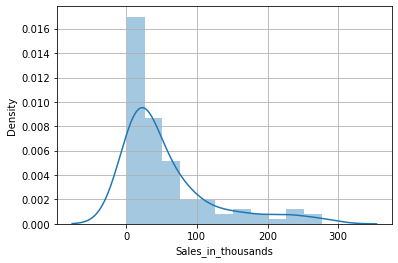

In [21]:
# Distribution of variables
sns.distplot(cars_new.Sales_in_thousands)
plt.show()

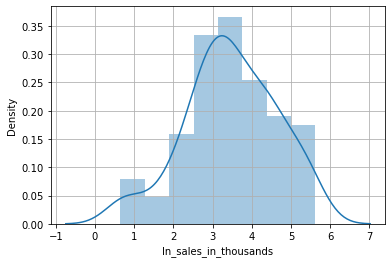

In [22]:
# apply log transformation: log is rescalling the data and making the distribution normal
cars_new['ln_sales_in_thousands'] = np.log(cars_new['Sales_in_thousands']+1)

# Distribution of variables
sns.distplot(cars_new.ln_sales_in_thousands)
plt.show()


In [53]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = cars_new.corr()
corrm.to_csv('corrm.csv')
corrm.head(5)

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,...,Manufacturer_Infiniti,Manufacturer_Jaguar,Manufacturer_Jeep,Manufacturer_Lexus,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Vehicle_type_Passenger,ln_sales_in_thousands
Sales_in_thousands,1.000000,-0.384701,-0.039084,-0.304806,0.341774,0.124665,0.211159,-0.038878,0.028757,0.001297,...,-0.051142,-0.063887,0.110648,-0.151466,-0.076414,-0.211680,-0.066558,-0.130095,-0.319960,0.839582
Price_in_thousands,-0.384701,1.000000,0.641957,0.831462,0.143819,0.291078,0.151022,0.551965,0.416075,-0.461092,...,0.004307,0.094836,-0.093112,0.259748,0.152745,0.504731,-0.137894,-0.123443,0.060004,-0.603365
Engine_size,-0.039084,0.641957,1.000000,0.837961,0.479869,0.706135,0.545047,0.786442,0.693986,-0.758654,...,-0.025213,-0.025213,0.040662,0.086818,0.272383,0.049115,-0.026833,-0.121694,-0.260924,-0.170391
Horsepower,-0.304806,0.831462,0.837961,1.000000,0.305491,0.505664,0.388665,0.645055,0.494570,-0.582252,...,0.058288,0.081796,-0.083633,0.232073,0.216938,0.211844,-0.140578,-0.146185,0.002402,-0.455603
Wheelbase,0.341774,0.143819,0.479869,0.305491,1.000000,0.684033,0.851888,0.642432,0.646681,-0.514071,...,-0.006325,0.071175,-0.187488,0.000335,0.140569,-0.094934,0.036985,-0.194150,-0.400306,0.295583


In [24]:
cars.columns

Index(['Manufacturer', 'Model', 'Sales_in_thousands', '__year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [26]:
cars_new.drop(['__year_resale_value'], axis = 1, inplace = True)

In [27]:
# dropping the variables based low correlation with Y
#cars_new.drop(['four_year_resale_value', 'Power_perf_factor'], axis = 1, inplace = True)
cars_new.head(5)

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,...,Manufacturer_Infiniti,Manufacturer_Jaguar,Manufacturer_Jeep,Manufacturer_Lexus,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Vehicle_type_Passenger,ln_sales_in_thousands
0,16.919,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,...,0,0,0,0,0,0,0,0,1,2.885862
1,39.384,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,...,0,0,0,0,0,0,0,0,1,3.698434
2,14.114,28.830623,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,...,0,0,0,0,0,0,0,0,1,2.715621
3,8.588,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,...,0,0,0,0,0,0,0,0,1,2.260512
4,20.397,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,...,0,0,0,0,0,0,0,0,1,3.063251


In [28]:
cars_new.shape

(101, 30)

In [29]:
# splitting the data: separate out the feature/input/independant columns and dependant variable
#cars_new.columns
feature_columns = cars_new.columns.difference(['ln_sales_in_thousands', 'Sales_in_thousands'])
feature_columns

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi', 'Price_in_thousands',
       'Vehicle_type_Passenger', 'Wheelbase', 'Width'],
      dtype='object')

In [32]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
x = cars_new.loc[:, feature_columns].values
scaled_data = standard.fit_transform(x)
scaled_data


array([[-1.33321966, -1.41501514, -1.33146355, ...,  0.60404045,
        -0.95074819, -1.29985877],
       [ 0.04309155, -0.05831857, -0.34644195, ...,  0.60404045,
        -0.0882487 , -0.43821676],
       [-0.03058343, -0.05831857, -0.34644195, ...,  0.60404045,
        -0.23824861, -0.35205256],
       ...,
       [-0.43344445, -0.05831857, -0.54344627, ...,  0.60404045,
        -0.36324854, -1.15625177],
       [ 0.98048802,  1.68600559,  1.13109046, ...,  0.60404045,
         0.5992509 ,  0.36598244],
       [ 1.40686234, -0.05831857,  0.09681777, ..., -1.65551827,
         0.27425109,  0.10748984]])

In [33]:
train_X, test_X, train_y, test_y = train_test_split(scaled_data,
                                                    cars_new['ln_sales_in_thousands'], test_size = 0.2, random_state = 1000)

In [34]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(train_X,train_y)


LinearRegression()

In [35]:
y_pred =  LR.predict(test_X)

In [36]:
mae=mean_absolute_error(test_y,y_pred)
mse=mean_squared_error(test_y,y_pred)
r2=r2_score(test_y,y_pred)
print("Mean Absolute Error:",mae)
print("Mean Squared Error:",mse)
print("R2 Score:",r2)

Mean Absolute Error: 0.6838780179007596
Mean Squared Error: 0.6670703218994839
R2 Score: 0.6630602803388224


In [133]:
print("Linear Regression")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_pred})
pred_df.head(10)

Linear Regression


,Actual Value,Predicted Value
37,4.279246,3.697881
97,0.926637,2.481541
56,5.626711,6.523986
55,5.401100,5.412050
33,3.997834,3.362431
84,2.512603,2.840881
3,2.260512,3.481335
4,3.063251,2.512318
72,1.466491,2.667088
59,4.306805,4.311010


Text(0.5, 1.0, 'Linear Regression')

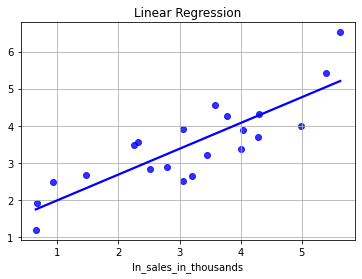

In [113]:
sns.regplot(x=test_y,y=y_pred,ci=None,color ='blue');
plt.title("Linear Regression")

## Applying Adaboost Regression

In [38]:
from sklearn.ensemble import AdaBoostRegressor
model=AdaBoostRegressor(n_estimators=40,random_state=4)
model.fit(train_X,train_y)


AdaBoostRegressor(n_estimators=40, random_state=4)

In [39]:
y_predAB=model.predict(test_X)
print("R2 Score Using Adaboost",r2_score(test_y,y_predAB))


R2 Score Using Adaboost 0.6104852873692055


In [134]:
print("Adaboost Regression")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_predAB})
pred_df.head(10)

Adaboost Regression


,Actual Value,Predicted Value
37,4.279246,3.240416
97,0.926637,2.782364
56,5.626711,4.741314
55,5.401100,4.860065
33,3.997834,3.659949
84,2.512603,3.054022
3,2.260512,3.237238
4,3.063251,3.160330
72,1.466491,2.196221
59,4.306805,3.488545


Text(0.5, 1.0, 'Adaboost Regression')

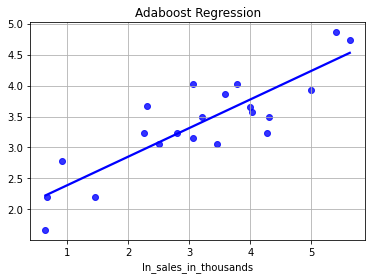

In [115]:
sns.regplot(x=test_y,y=y_predAB,ci=None,color ='blue');
plt.title("Adaboost Regression")

## Applying Random Forest Regression

In [41]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=15,random_state=4)
model.fit(train_X,train_y)


RandomForestRegressor(n_estimators=15, random_state=4)

In [42]:
y_predRF=model.predict(test_X)
r2=r2_score(test_y,y_predRF)
print(r2)

0.6586800762961482


In [135]:
print("Random Forest Regression")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_predRF})
pred_df.head(10)

Random Forest Regression


,Actual Value,Predicted Value
37,4.279246,3.359184
97,0.926637,2.493229
56,5.626711,4.634086
55,5.401100,4.912153
33,3.997834,3.639119
84,2.512603,3.234227
3,2.260512,3.060825
4,3.063251,3.233639
72,1.466491,2.392597
59,4.306805,4.248885


Text(0.5, 1.0, 'Random Forest')

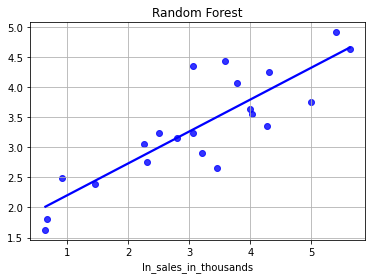

In [117]:
sns.regplot(x=test_y,y=y_predRF,ci=None,color ='blue');
plt.title("Random Forest")

## Applying KNN Regression

In [118]:
from sklearn import neighbors
r2_val={}
for k in range(50):
    k=k+1
    model=neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(train_X,train_y)
    y_predKNN=model.predict(test_X)
    r2=r2_score(test_y,y_predKNN)
    r2_val[k]=r2
    
v=list(r2_val.values())
k=list(r2_val.keys())
print("max r2 score in KNN: ",max(v))


max r2 score in KNN:  0.5582305706969565


In [136]:
print("KNeighbors")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_predKNN})
pred_df.head(10)

KNeighbors


,Actual Value,Predicted Value
37,4.279246,3.654227
97,0.926637,3.500414
56,5.626711,3.657452
55,5.401100,3.687144
33,3.997834,3.634456
84,2.512603,3.515711
3,2.260512,3.586826
4,3.063251,3.507082
72,1.466491,3.457464
59,4.306805,3.658822


Text(0.5, 1.0, 'KNeighbors')

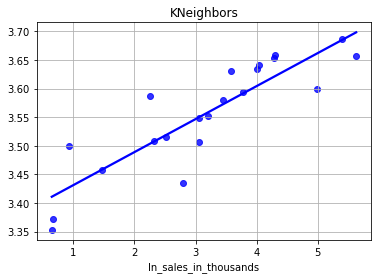

In [120]:
sns.regplot(x=test_y,y=y_predKNN,ci=None,color ='blue');
plt.title("KNeighbors")

## Applying Support Vector Machines SVM Regression

In [122]:
from sklearn.svm import SVR
model=SVR(kernel='rbf')
model.fit(train_X,train_y.ravel())


SVR()

In [123]:
y_predSVM=model.predict(test_X)
r2=r2_score(test_y,y_predSVM)
print("R2 Score in SVR",r2)

R2 Score in SVR 0.4910363949268538


In [137]:
print("Support Vector regression")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_predSVM})
pred_df.head(10)

Support Vector regression


,Actual Value,Predicted Value
37,4.279246,4.155770
97,0.926637,2.319897
56,5.626711,4.485645
55,5.401100,5.193415
33,3.997834,3.466799
84,2.512603,3.369235
3,2.260512,3.591530
4,3.063251,3.175322
72,1.466491,2.586930
59,4.306805,4.368403


Text(0.5, 1.0, 'SVR')

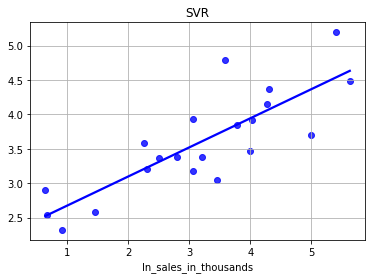

In [125]:
sns.regplot(x=test_y,y=y_predSVM,ci=None,color ='blue');
plt.title("SVR")

In [126]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(ccp_alpha=0.02,random_state=30)
dtree.fit(train_X,train_y)
y_predDT=dtree.predict(test_X)
print("Decision Tree r2 score")
r2_score(test_y,y_predDT)

Decision Tree r2 score


0.4999986853118058

In [138]:
print("Decision Tree")
pred_df=pd.DataFrame({'Actual Value':test_y,'Predicted Value':y_predDT})
pred_df.head(10)

Decision Tree


,Actual Value,Predicted Value
37,4.279246,4.584217
97,0.926637,1.436137
56,5.626711,5.232836
55,5.401100,4.818046
33,3.997834,3.212093
84,2.512603,3.212093
3,2.260512,3.652729
4,3.063251,3.009869
72,1.466491,3.009869
59,4.306805,5.301737


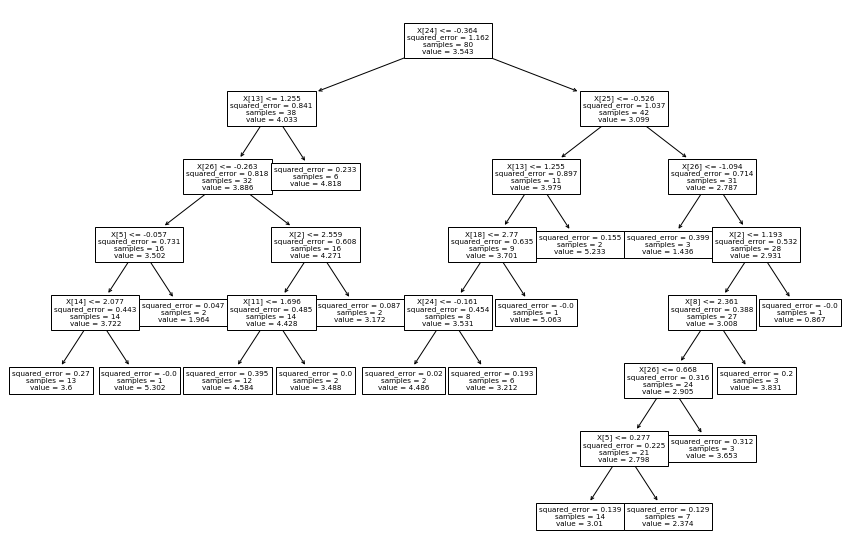

In [130]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(dtree)
plt.show()

Text(0.5, 1.0, 'Decision Tree')

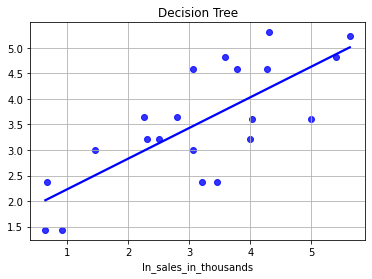

In [132]:
sns.regplot(x=test_y,y=y_predDT,ci=None,color ='blue');
plt.title("Decision Tree")

In [175]:
result=pd.DataFrame({'test values':test_y,
    'Linear Regression':y_pred,'Adaboost':y_predAB,'Random Forest':y_predRF,'KNeighbors':y_predKNN,'SVR':y_predSVM,'Decision Tree':y_predDT})
result.head(10)

,test values,Linear Regression,Adaboost,Random Forest,KNeighbors,SVR,Decision Tree
37,4.279246,3.697881,3.240416,3.359184,3.654227,4.155770,4.584217
97,0.926637,2.481541,2.782364,2.493229,3.500414,2.319897,1.436137
56,5.626711,6.523986,4.741314,4.634086,3.657452,4.485645,5.232836
55,5.401100,5.412050,4.860065,4.912153,3.687144,5.193415,4.818046
33,3.997834,3.362431,3.659949,3.639119,3.634456,3.466799,3.212093
84,2.512603,2.840881,3.054022,3.234227,3.515711,3.369235,3.212093
3,2.260512,3.481335,3.237238,3.060825,3.586826,3.591530,3.652729
4,3.063251,2.512318,3.160330,3.233639,3.507082,3.175322,3.009869
72,1.466491,2.667088,2.196221,2.392597,3.457464,2.586930,3.009869
59,4.306805,4.311010,3.488545,4.248885,3.658822,4.368403,5.301737


<AxesSubplot:xlabel='Test Values', ylabel='Methods'>

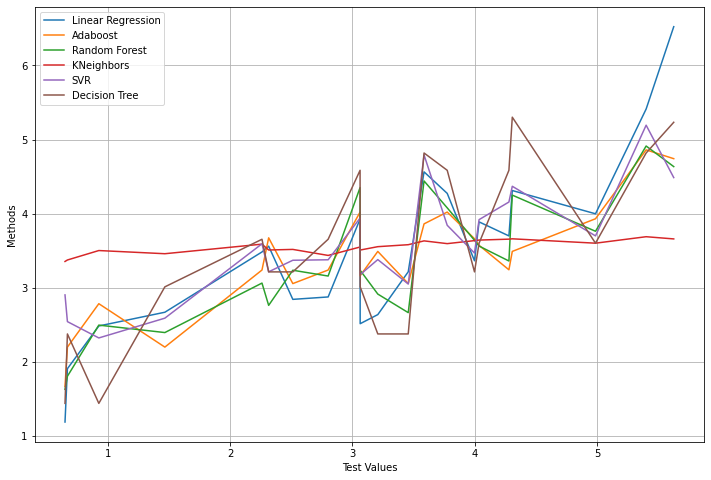

In [174]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.xlabel('Test Values')
plt.ylabel('Methods')
sns.lineplot(x=result['test values'],y=result['Linear Regression'],data=result,label='Linear Regression')
sns.lineplot(x=result['test values'],y=result['Adaboost'],data=result,label='Adaboost')
sns.lineplot(x=result['test values'],y=result['Random Forest'],data=result,label='Random Forest')
sns.lineplot(x=result['test values'],y=result['KNeighbors'],data=result,label='KNeighbors')
sns.lineplot(x=result['test values'],y=result['SVR'],data=result,label='SVR')
sns.lineplot(x=result['test values'],y=result['Decision Tree'],data=result,label='Decision Tree')